### Reference

* https://github.com/zhouhaoyi/Informer2020/tree/main
* https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-5.informer-post/

### Import Library

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from math import sqrt
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from models.model import Informer

### Data Directory

In [2]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [3]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [4]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

### Informer

In [12]:
from models.model import Informer

### Tools for predict

In [6]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_[[date]+target], test_df_[[date]+target], mean_dict, std_dict

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [7]:
from datetime import timedelta
# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='m'):
    dates['year'] = dates.date.apply(lambda x: x.year)
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m': ['year', 'month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta >= timedelta(days=28):  # 데이터가 월별로 제공된다고 가정
            self.freq = 'm'
        else:
            self.freq = 'd'  # 기본값을 일별로 설정
        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

### Common Experiment Setting

In [8]:
window_size = 3
forecast_size= 3 
label_len = window_size
pred_len = forecast_size

train_df = df[0:177]
test_df = df[177-forecast_size:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [9]:
### Experiment Setting
version = "V1"
batch_size = 16
epoch_ = 500
lr = 0.00008
patience = 100  # easrly stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status"] \
                    + nf.columns.tolist()

In [13]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Informer(
    enc_in = len(columns_to_use),
    dec_in = len(columns_to_use),
    c_out = len(columns_to_use),
    seq_len = window_size, # 입력 크기
    label_len = window_size, # 디코더에서 참고할 크기 
    out_len = forecast_size, # 예측할 크기 
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:7: FutureW

 27%|██▋       | 137/500 [06:26<17:04,  2.82s/it]

Early stopping triggered.


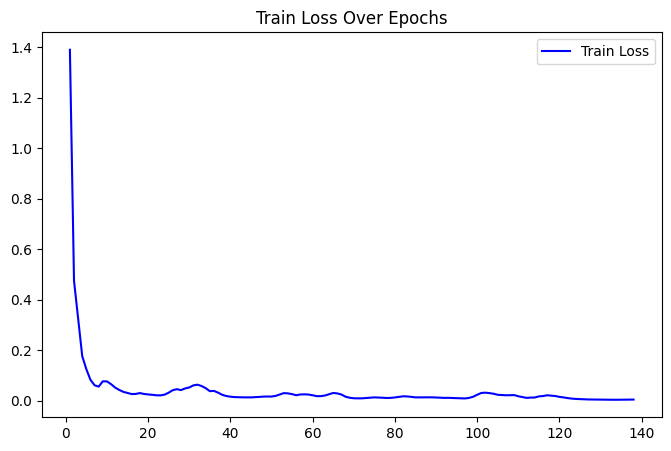

In [253]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_dl):
        optimizer.zero_grad()
        # batch_size = 16
        # seq_len = 3
        # pred_len = 3
        # label_len = 3
        # features = 20
        batch_x = batch_x.float()  # shape = [16, 3, 20]
        batch_y = batch_y.float() # shape = [16, 6, 20]
        batch_x_mark = batch_x_mark.float() # shape = [16, 3, 4]
        batch_y_mark = batch_y_mark.float() # shape = [16, 6, 4]
        
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        target = batch_y[:,-pred_len:,:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./Informer{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='b')
plt.legend()
plt.title('Train Loss Over Epochs')
plt.show()

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1673/3481014827.py:7: FutureW

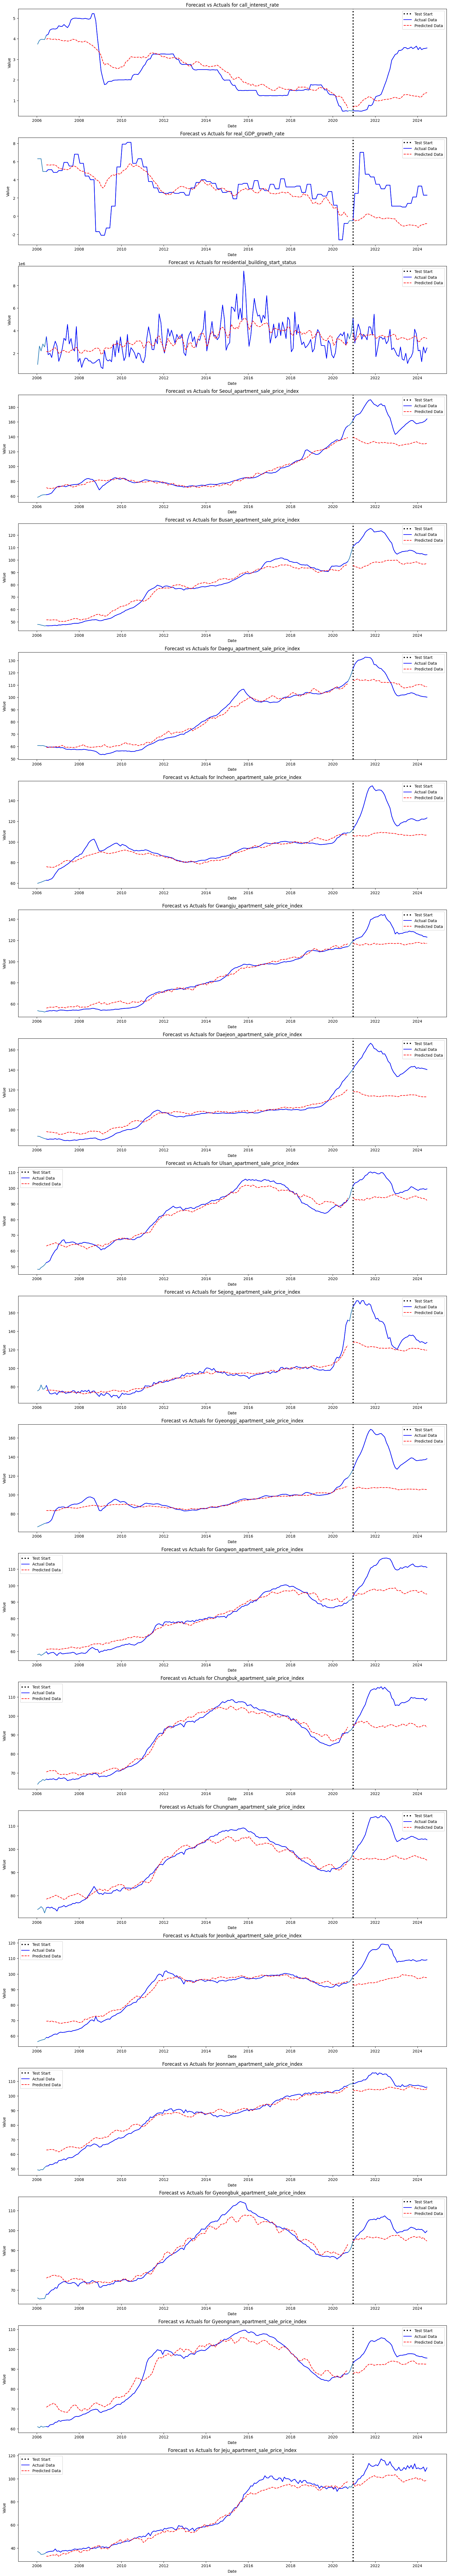

In [14]:
# Load model and Evaluate
model.load_state_dict(torch.load(f"./Informer{version}.pth"))  # 최적 모델 로드
model.eval()

train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=len(train_df),shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

with torch.no_grad():
    for batch_x,batch_y,batch_x_mark,batch_y_mark in train_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        train_predicted = output[:,-1,:].cpu().numpy()
        train_actual = target[:,-1,:].cpu().numpy()
    
    for batch_x,batch_y,batch_x_mark,batch_y_mark in test_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        test_predicted = output[:,-1,:].cpu().numpy()
        test_actual = target[:,-1,:].cpu().numpy()
        
train_dates = train_df.date[window_size+forecast_size-1:]
test_dates = test_df.date[window_size+forecast_size-1:]
test_dates = test_dates.reset_index(drop=True)    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df[date], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)


### Train and Save model (Input V2: All variables used in FA-SEM-MLP)
* input: "call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg", "KOSPI_index", "KOSDAQ_index", "NASDAQ_index", "M2_Korea", "M2_USA", "broad_liquidity", "CPI_growth_rate", "USD_KRW_exchange_rate", "real_GDP_growth_rate", "residential_building_start_status", "residential_building_permit_status", "construction_production_index_seasonally_adjusted", 
f"{target}"
* window_size = 3
* forecast_size= 3 

In [256]:
### Experiment Setting
version = "V2"
batch_size = 16
epoch_ = 500
lr = 0.00008
patience = 100  # easrly stopping

columns_to_use = column + nf.columns.tolist()

In [257]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Informer(
    enc_in = len(columns_to_use),
    dec_in = len(columns_to_use),
    c_out = len(columns_to_use),
    seq_len = window_size, # 입력 크기
    label_len = window_size, # 디코더에서 참고할 크기 
    out_len = forecast_size, # 예측할 크기 
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:7: Fut

 29%|██▊       | 143/500 [08:20<20:48,  3.50s/it]

Early stopping triggered.


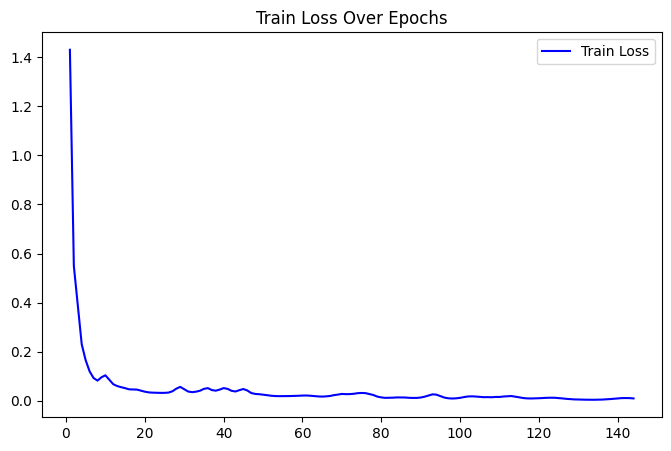

In [259]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_dl):
        optimizer.zero_grad()
        # batch_size = 16
        # seq_len = 3
        # pred_len = 3
        # label_len = 3
        # features = 20
        batch_x = batch_x.float()  # shape = [16, 3, 20]
        batch_y = batch_y.float() # shape = [16, 6, 20]
        batch_x_mark = batch_x_mark.float() # shape = [16, 3, 4]
        batch_y_mark = batch_y_mark.float() # shape = [16, 6, 4]
        
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        target = batch_y[:,-pred_len:,:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./Informer{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='b')
plt.legend()
plt.title('Train Loss Over Epochs')
plt.show()

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:7: Fut

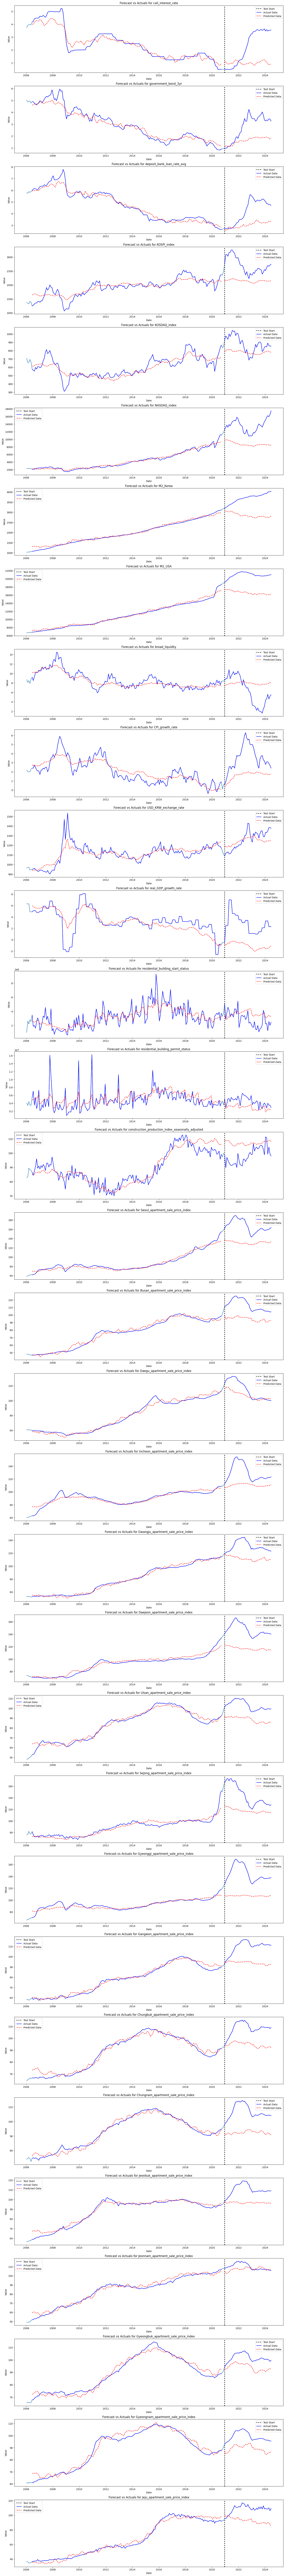

In [260]:
# Load model and Evaluate
model.load_state_dict(torch.load(f"./Informer{version}.pth"))  # 최적 모델 로드
model.eval()

train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=len(train_df),shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

with torch.no_grad():
    for batch_x,batch_y,batch_x_mark,batch_y_mark in train_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        train_predicted = output[:,-1,:].cpu().numpy()
        train_actual = target[:,-1,:].cpu().numpy()
    
    for batch_x,batch_y,batch_x_mark,batch_y_mark in test_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        test_predicted = output[:,-1,:].cpu().numpy()
        test_actual = target[:,-1,:].cpu().numpy()
        
train_dates = train_df.date[window_size+forecast_size-1:]
test_dates = test_df.date[window_size+forecast_size-1:]
test_dates = test_dates.reset_index(drop=True)    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df[date], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)


### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [261]:
### Experiment Setting
version = "V3"
batch_size = 16
epoch_ = 500
lr = 0.00008
patience = 100  # easrly stopping

columns_to_use = nf.columns.tolist()

In [262]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Informer(
    enc_in = len(columns_to_use),
    dec_in = len(columns_to_use),
    c_out = len(columns_to_use),
    seq_len = window_size, # 입력 크기
    label_len = window_size, # 디코더에서 참고할 크기 
    out_len = forecast_size, # 예측할 크기 
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:7: Fut

 25%|██▌       | 127/500 [59:21<2:54:20, 28.05s/it] 

Early stopping triggered.


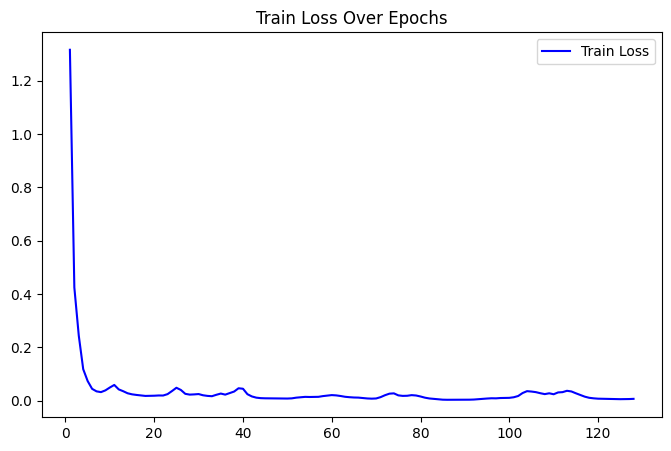

In [263]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_dl):
        optimizer.zero_grad()
        # batch_size = 16
        # seq_len = 3
        # pred_len = 3
        # label_len = 3
        # features = 20
        batch_x = batch_x.float()  # shape = [16, 3, 20]
        batch_y = batch_y.float() # shape = [16, 6, 20]
        batch_x_mark = batch_x_mark.float() # shape = [16, 3, 4]
        batch_y_mark = batch_y_mark.float() # shape = [16, 6, 4]
        
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        target = batch_y[:,-pred_len:,:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./Informer{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='b')
plt.legend()
plt.title('Train Loss Over Epochs')
plt.show()

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_73737/3481014827.py:7: Fut

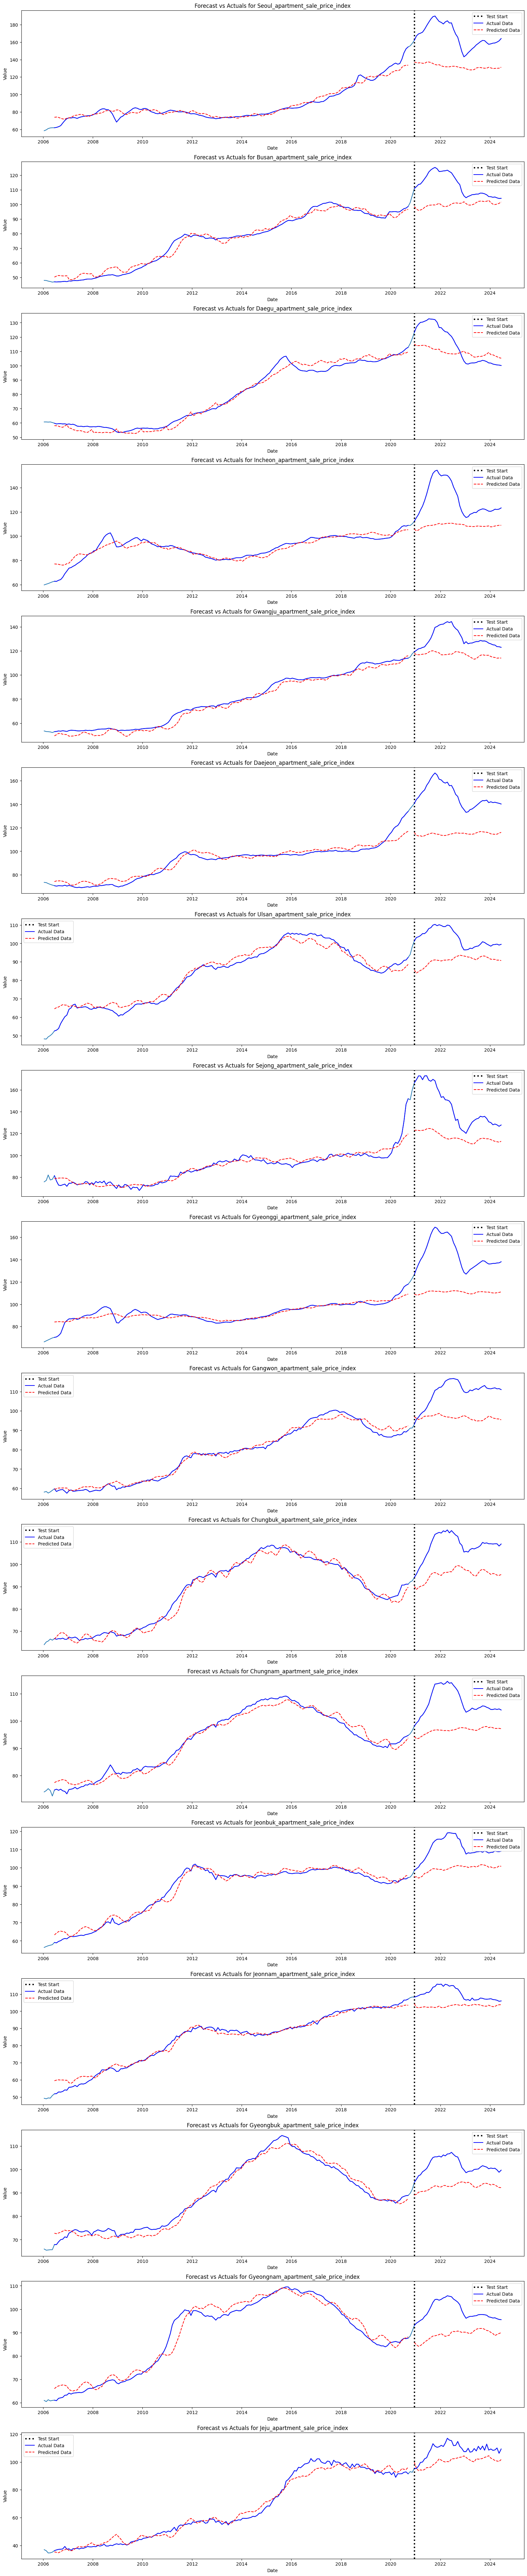

In [264]:
# Load model and Evaluate
model.load_state_dict(torch.load(f"./Informer{version}.pth"))  # 최적 모델 로드
model.eval()

train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=len(train_df),shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

with torch.no_grad():
    for batch_x,batch_y,batch_x_mark,batch_y_mark in train_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        train_predicted = output[:,-1,:].cpu().numpy()
        train_actual = target[:,-1,:].cpu().numpy()
    
    for batch_x,batch_y,batch_x_mark,batch_y_mark in test_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        test_predicted = output[:,-1,:].cpu().numpy()
        test_actual = target[:,-1,:].cpu().numpy()
        
train_dates = train_df.date[window_size+forecast_size-1:]
test_dates = test_df.date[window_size+forecast_size-1:]
test_dates = test_dates.reset_index(drop=True)    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df[date], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
